In [1]:
!pip install efficientnet_pytorch
! pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=37db3d07aa4a071547f70e733ac613ac0489e58efaf66d9d3

In [2]:
# Importación de bibliotecas necesarias
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from PIL import Image
import pandas as pd
import numpy as np
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history

In [3]:
# Configuración del dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Definición de rutas de archivos y carga de metadatos
csv_file_path = 'Proyecto/poi_dataset.csv'
images_dir = 'Proyecto/data_main/data_main'
metadata = pd.read_csv(csv_file_path)

In [5]:
def perform_eda(metadata):
    print(metadata.describe())  # Estadísticas descriptivas
    plot_engagement_distribution(metadata)
    plot_engagement_classes(metadata)

def plot_engagement_distribution(metadata):
    plt.figure(figsize=(12, 6))
    sns.histplot(metadata['Likes'] / (metadata['Visits'] + 1e-5), bins=50, kde=True)
    plt.title('Distribución del Engagement')
    plt.xlabel('Engagement (Likes/Visits)')
    plt.ylabel('Frecuencia')
    plt.show()

def plot_engagement_classes(metadata):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=(metadata['Likes'] / (metadata['Visits'] + 1e-5) > 0.1).astype(int))
    plt.title('Distribución de Clases de Engagement')
    plt.xlabel('Engagement (0: Bajo, 1: Alto)')
    plt.ylabel('Número de POIs')
    plt.show()


              tier  locationLon  locationLat          xps        Visits  \
count  1569.000000  1569.000000  1569.000000  1569.000000   1569.000000   
mean      1.541109    -1.132337    39.900141   750.382409  10011.943276   
std       0.637677    22.733401     9.662134   228.319854      5.456808   
min       1.000000  -121.951049   -62.940930     0.000000  10001.000000   
25%       1.000000    -3.725292    40.411754   600.000000  10008.000000   
50%       1.000000    -3.699140    40.421738   700.000000  10011.000000   
75%       2.000000    -3.673348    40.472458  1000.000000  10015.000000   
max       4.000000   158.333118    65.706572  1000.000000  10038.000000   

              Likes      Dislikes    Bookmarks  
count   1569.000000   1569.000000  1569.000000  
mean    3623.908222   2526.305927   973.261950  
std     4817.879374   2225.543360  1453.333948  
min      100.000000     52.000000    50.000000  
25%      464.000000    937.000000   116.000000  
50%     1434.000000   2718.000

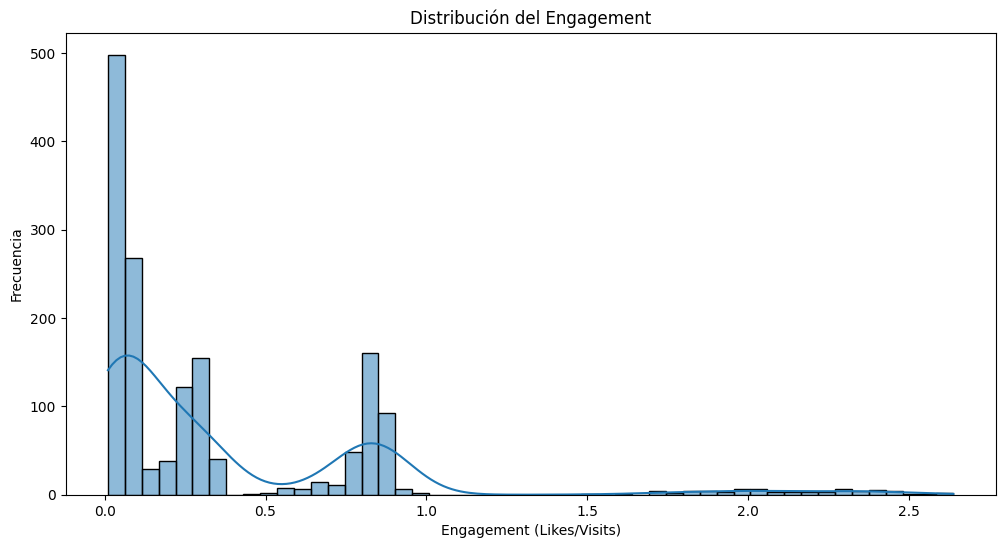

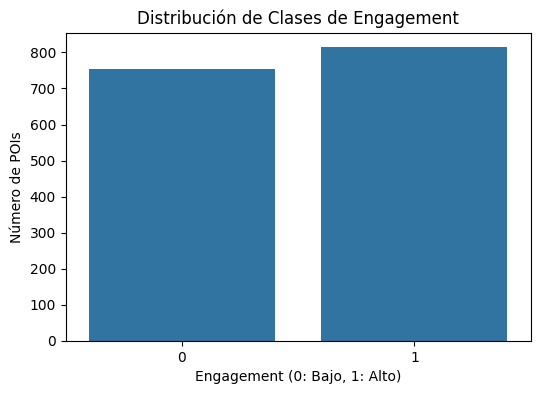

In [6]:
# Realizar análisis exploratorio
perform_eda(metadata)

In [7]:
# Crear etiqueta de engagement
metadata['engagement'] = (metadata['Likes'] - metadata['Dislikes'] + metadata['Bookmarks'] > 0).astype(int)

# Codificación de variables categóricas
metadata = pd.get_dummies(metadata, columns=['tier'], prefix='tier')

In [8]:
# División de datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(metadata, test_size=0.2, stratify=metadata['engagement'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['engagement'], random_state=42)

In [9]:
# Definición de transformaciones para las imágenes
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [10]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from PIL import Image
import torch

class POIDataset(Dataset):
    def __init__(self, metadata, images_dir, transform=None):
        self.metadata = metadata
        self.images_dir = images_dir
        self.transform = transform
        self.scaler = StandardScaler()
        self._scale_metadata()

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        metadata_features = self._get_metadata_features(row)
        label = torch.tensor(row['engagement'], dtype=torch.float32)
        image = self._load_and_transform_image(row['main_image_path'])
        return image, metadata_features, label

    def _scale_metadata(self):
        columns_to_scale = ['locationLat', 'locationLon', 'xps']
        self.metadata[columns_to_scale] = self.scaler.fit_transform(self.metadata[columns_to_scale])

    def _get_metadata_features(self, row):
        feature_columns = ['locationLat', 'locationLon', 'xps'] + [col for col in self.metadata.columns if col.startswith('tier_')]
        return torch.tensor(row[feature_columns].values.astype(np.float32))

    def _load_and_transform_image(self, image_path):
        img_path = os.path.join(self.images_dir, image_path)
        image = self._load_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

    def _load_image(self, img_path):
        try:
            return Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            return Image.new('RGB', (224, 224), color=(0, 0, 0))


In [11]:
# Implementación de balance de clases
def get_weighted_sampler(train_data):
    class_counts = train_data['engagement'].value_counts().to_list()
    weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    samples_weights = weights[train_data['engagement'].values]
    return WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

In [12]:
# Creación de datasets y dataloaders
train_dataset = POIDataset(train_data, images_dir, transform=get_transforms(train=True))
val_dataset = POIDataset(val_data, images_dir, transform=get_transforms(train=False))
test_dataset = POIDataset(test_data, images_dir, transform=get_transforms(train=False))

sampler = get_weighted_sampler(train_data)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torchvision import models

class CombinedModel(nn.Module):
    def __init__(self, num_metadata_features, dropout):
        super(CombinedModel, self).__init__()
        self.efficientnet = self._initialize_efficientnet()
        self.resnet = self._initialize_resnet()
        self.metadata_fc = self._create_metadata_fc(num_metadata_features, dropout)
        self.fc = self._create_final_fc(dropout)

    def _initialize_efficientnet(self):
        efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        efficientnet._fc = nn.Identity()
        self._freeze_parameters(efficientnet)
        self._unfreeze_parameters(efficientnet._conv_head)
        return efficientnet

    def _initialize_resnet(self):
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        resnet.fc = nn.Identity()
        self._freeze_parameters(resnet)
        self._unfreeze_parameters(resnet.layer4)
        return resnet

    def _freeze_parameters(self, model):
        for param in model.parameters():
            param.requires_grad = False

    def _unfreeze_parameters(self, layer):
        for param in layer.parameters():
            param.requires_grad = True

    def _create_metadata_fc(self, num_features, dropout):
        return nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def _create_final_fc(self, dropout):
        return nn.Sequential(
            nn.Linear(1280 + 512 + 128, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x_img, x_metadata):
        efficientnet_out = self.efficientnet(x_img)
        resnet_out = self.resnet(x_img)
        metadata_out = self.metadata_fc(x_metadata)
        combined = torch.cat((efficientnet_out, resnet_out, metadata_out), dim=1)
        return self.fc(combined)


In [14]:
# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, correct_train, total_train = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, correct_val, total_val = validate_model(model, val_loader, criterion)

        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accs, val_accs

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    for images, metadata, labels in train_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    return train_loss / len(train_loader), correct_train, total_train

In [16]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, metadata, labels in val_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    return val_loss / len(val_loader), correct_val, total_val

# Función de evaluación
def evaluate_model(model, test_loader):
    model.eval()
    test_predictions, test_labels = [], []
    with torch.no_grad():
        for images, metadata, labels in test_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()
            test_predictions.extend((outputs > 0.5).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    return calculate_metrics(test_labels, test_predictions)

def calculate_metrics(test_labels, test_predictions):
    test_f1 = f1_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions)
    test_recall = recall_score(test_labels, test_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy



In [17]:
# Función objetivo para optimización con Optuna
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    num_epochs = trial.suggest_int("num_epochs", 5, 20)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    model = CombinedModel(num_metadata_features=7, dropout=dropout).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping)
    accuracy = evaluate_model(model, val_loader)
    return accuracy

# Creación y optimización del estudio con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)



[I 2025-03-01 14:53:15,232] A new study created in memory with name: no-name-9f575b65-4ad1-42e9-bcfd-010965acdae7
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 290MB/s]


Loaded pretrained weights for efficientnet-b0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.9MB/s]


Epoch 1/15, Train Loss: 0.6955, Train Acc: 0.5048, Val Loss: 0.6901, Val Acc: 0.4745
Validation loss decreased (inf --> 0.690140). Saving model ...
Epoch 2/15, Train Loss: 0.6846, Train Acc: 0.5558, Val Loss: 0.6838, Val Acc: 0.5955
Validation loss decreased (0.690140 --> 0.683755). Saving model ...
Epoch 3/15, Train Loss: 0.6859, Train Acc: 0.5271, Val Loss: 0.6763, Val Acc: 0.6433
Validation loss decreased (0.683755 --> 0.676344). Saving model ...
Epoch 4/15, Train Loss: 0.6828, Train Acc: 0.5600, Val Loss: 0.6843, Val Acc: 0.5064
Epoch 5/15, Train Loss: 0.6807, Train Acc: 0.5452, Val Loss: 0.6854, Val Acc: 0.5064
Epoch 6/15, Train Loss: 0.6795, Train Acc: 0.5845, Val Loss: 0.6771, Val Acc: 0.5955
Epoch 7/15, Train Loss: 0.6759, Train Acc: 0.5983, Val Loss: 0.6696, Val Acc: 0.5987
Validation loss decreased (0.676344 --> 0.669560). Saving model ...
Epoch 8/15, Train Loss: 0.6619, Train Acc: 0.6259, Val Loss: 0.6773, Val Acc: 0.5955
Epoch 9/15, Train Loss: 0.6886, Train Acc: 0.5749, Va

[I 2025-03-01 14:55:46,096] Trial 0 finished with value: 0.5955414012738853 and parameters: {'lr': 7.712729540091739e-05, 'dropout': 0.10686817376439586, 'num_epochs': 15, 'batch_size': 32, 'weight_decay': 0.0018274774124654176}. Best is trial 0 with value: 0.5955414012738853.


Test Accuracy: 0.5955, F1-score: 0.5890, Precision: 0.5687, Recall: 0.6107
Loaded pretrained weights for efficientnet-b0
Epoch 1/12, Train Loss: 0.7070, Train Acc: 0.5133, Val Loss: 0.6795, Val Acc: 0.6401
Validation loss decreased (inf --> 0.679489). Saving model ...
Epoch 2/12, Train Loss: 0.6836, Train Acc: 0.5484, Val Loss: 0.6772, Val Acc: 0.5955
Validation loss decreased (0.679489 --> 0.677246). Saving model ...
Epoch 3/12, Train Loss: 0.6825, Train Acc: 0.5685, Val Loss: 0.6755, Val Acc: 0.5955
Validation loss decreased (0.677246 --> 0.675492). Saving model ...
Epoch 4/12, Train Loss: 0.6744, Train Acc: 0.5813, Val Loss: 0.6715, Val Acc: 0.5955
Validation loss decreased (0.675492 --> 0.671548). Saving model ...
Epoch 5/12, Train Loss: 0.6806, Train Acc: 0.5792, Val Loss: 0.6712, Val Acc: 0.5955
Validation loss decreased (0.671548 --> 0.671240). Saving model ...
Epoch 6/12, Train Loss: 0.6742, Train Acc: 0.5855, Val Loss: 0.6654, Val Acc: 0.6433
Validation loss decreased (0.67124

[I 2025-03-01 14:57:37,771] Trial 1 finished with value: 0.6401273885350318 and parameters: {'lr': 0.0003131504121326345, 'dropout': 0.33657200250601604, 'num_epochs': 12, 'batch_size': 32, 'weight_decay': 0.001368318985331769}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.6401, F1-score: 0.5891, Precision: 0.6429, Recall: 0.5436
Loaded pretrained weights for efficientnet-b0
Epoch 1/14, Train Loss: 0.7096, Train Acc: 0.5112, Val Loss: 0.6894, Val Acc: 0.5255
Validation loss decreased (inf --> 0.689409). Saving model ...
Epoch 2/14, Train Loss: 0.6972, Train Acc: 0.5058, Val Loss: 0.6816, Val Acc: 0.6465
Validation loss decreased (0.689409 --> 0.681637). Saving model ...
Epoch 3/14, Train Loss: 0.6877, Train Acc: 0.5335, Val Loss: 0.6827, Val Acc: 0.5987
Epoch 4/14, Train Loss: 0.6785, Train Acc: 0.5643, Val Loss: 0.6810, Val Acc: 0.5987
Validation loss decreased (0.681637 --> 0.681033). Saving model ...
Epoch 5/14, Train Loss: 0.6843, Train Acc: 0.5675, Val Loss: 0.6774, Val Acc: 0.5987
Validation loss decreased (0.681033 --> 0.677430). Saving model ...
Epoch 6/14, Train Loss: 0.6878, Train Acc: 0.5632, Val Loss: 0.6760, Val Acc: 0.5955
Validation loss decreased (0.677430 --> 0.675956). Saving model ...
Epoch 7/14, Train Loss: 0.6877, Tr

[I 2025-03-01 14:59:48,392] Trial 2 finished with value: 0.5955414012738853 and parameters: {'lr': 0.0002825910231325912, 'dropout': 0.48196578213215246, 'num_epochs': 14, 'batch_size': 64, 'weight_decay': 0.0033515649989106547}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.5955, F1-score: 0.5890, Precision: 0.5687, Recall: 0.6107
Loaded pretrained weights for efficientnet-b0
Epoch 1/13, Train Loss: 0.6964, Train Acc: 0.5101, Val Loss: 0.6894, Val Acc: 0.5955
Validation loss decreased (inf --> 0.689365). Saving model ...
Epoch 2/13, Train Loss: 0.6860, Train Acc: 0.5345, Val Loss: 0.6857, Val Acc: 0.5955
Validation loss decreased (0.689365 --> 0.685722). Saving model ...
Epoch 3/13, Train Loss: 0.6874, Train Acc: 0.5558, Val Loss: 0.6802, Val Acc: 0.6306
Validation loss decreased (0.685722 --> 0.680165). Saving model ...
Epoch 4/13, Train Loss: 0.6875, Train Acc: 0.5505, Val Loss: 0.6784, Val Acc: 0.6401
Validation loss decreased (0.680165 --> 0.678393). Saving model ...
Epoch 5/13, Train Loss: 0.6855, Train Acc: 0.5441, Val Loss: 0.6768, Val Acc: 0.5478
Validation loss decreased (0.678393 --> 0.676759). Saving model ...
Epoch 6/13, Train Loss: 0.6884, Train Acc: 0.5313, Val Loss: 0.6759, Val Acc: 0.6401
Validation loss decreased (0.67675

[I 2025-03-01 15:01:46,550] Trial 3 finished with value: 0.5955414012738853 and parameters: {'lr': 4.565398089122835e-05, 'dropout': 0.14965967772432803, 'num_epochs': 13, 'batch_size': 32, 'weight_decay': 0.0001244045138388148}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.5955, F1-score: 0.5890, Precision: 0.5687, Recall: 0.6107
Loaded pretrained weights for efficientnet-b0
Epoch 1/11, Train Loss: 0.7844, Train Acc: 0.5218, Val Loss: 0.6745, Val Acc: 0.5955
Validation loss decreased (inf --> 0.674490). Saving model ...
Epoch 2/11, Train Loss: 0.6859, Train Acc: 0.5919, Val Loss: 0.6900, Val Acc: 0.5064
Epoch 3/11, Train Loss: 0.6818, Train Acc: 0.5994, Val Loss: 0.6758, Val Acc: 0.5955
Epoch 4/11, Train Loss: 0.6839, Train Acc: 0.5760, Val Loss: 0.7018, Val Acc: 0.4841
Epoch 5/11, Train Loss: 0.6836, Train Acc: 0.5802, Val Loss: 0.6704, Val Acc: 0.5955
Validation loss decreased (0.674490 --> 0.670370). Saving model ...
Epoch 6/11, Train Loss: 0.6789, Train Acc: 0.6047, Val Loss: 0.6697, Val Acc: 0.5955
Validation loss decreased (0.670370 --> 0.669694). Saving model ...
Epoch 7/11, Train Loss: 0.6805, Train Acc: 0.5887, Val Loss: 0.6635, Val Acc: 0.5987
Validation loss decreased (0.669694 --> 0.663457). Saving model ...
Epoch 8/11, Train

[I 2025-03-01 15:03:28,340] Trial 4 finished with value: 0.4745222929936306 and parameters: {'lr': 0.002611741739196014, 'dropout': 0.3210628329875401, 'num_epochs': 11, 'batch_size': 16, 'weight_decay': 0.00014512581441531035}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.4745, F1-score: 0.6436, Precision: 0.4745, Recall: 1.0000
Loaded pretrained weights for efficientnet-b0
Epoch 1/12, Train Loss: 0.7082, Train Acc: 0.5165, Val Loss: 0.6737, Val Acc: 0.5955
Validation loss decreased (inf --> 0.673653). Saving model ...
Epoch 2/12, Train Loss: 0.6848, Train Acc: 0.5526, Val Loss: 0.6694, Val Acc: 0.5987
Validation loss decreased (0.673653 --> 0.669356). Saving model ...
Epoch 3/12, Train Loss: 0.6790, Train Acc: 0.5866, Val Loss: 0.6689, Val Acc: 0.5987
Validation loss decreased (0.669356 --> 0.668917). Saving model ...
Epoch 4/12, Train Loss: 0.6865, Train Acc: 0.5484, Val Loss: 0.6706, Val Acc: 0.5955
Epoch 5/12, Train Loss: 0.6877, Train Acc: 0.5537, Val Loss: 0.6789, Val Acc: 0.5955
Epoch 6/12, Train Loss: 0.6859, Train Acc: 0.5664, Val Loss: 0.6728, Val Acc: 0.5955
Epoch 7/12, Train Loss: 0.6848, Train Acc: 0.5792, Val Loss: 0.6780, Val Acc: 0.5955
Epoch 8/12, Train Loss: 0.6855, Train Acc: 0.5717, Val Loss: 0.6773, Val Acc: 0.5955


[I 2025-03-01 15:04:42,681] Trial 5 finished with value: 0.5955414012738853 and parameters: {'lr': 0.0007047412313453332, 'dropout': 0.35253578712803935, 'num_epochs': 12, 'batch_size': 16, 'weight_decay': 0.003951894814105555}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.5955, F1-score: 0.5890, Precision: 0.5687, Recall: 0.6107
Loaded pretrained weights for efficientnet-b0
Epoch 1/16, Train Loss: 0.7008, Train Acc: 0.5027, Val Loss: 0.7039, Val Acc: 0.4745
Validation loss decreased (inf --> 0.703886). Saving model ...
Epoch 2/16, Train Loss: 0.6897, Train Acc: 0.5218, Val Loss: 0.6884, Val Acc: 0.5287
Validation loss decreased (0.703886 --> 0.688374). Saving model ...
Epoch 3/16, Train Loss: 0.6897, Train Acc: 0.5313, Val Loss: 0.6913, Val Acc: 0.4809
Epoch 4/16, Train Loss: 0.6841, Train Acc: 0.5749, Val Loss: 0.6842, Val Acc: 0.6338
Validation loss decreased (0.688374 --> 0.684243). Saving model ...
Epoch 5/16, Train Loss: 0.6961, Train Acc: 0.5175, Val Loss: 0.6916, Val Acc: 0.4809
Epoch 6/16, Train Loss: 0.6840, Train Acc: 0.5675, Val Loss: 0.6828, Val Acc: 0.5987
Validation loss decreased (0.684243 --> 0.682789). Saving model ...
Epoch 7/16, Train Loss: 0.6871, Train Acc: 0.5409, Val Loss: 0.6942, Val Acc: 0.4809
Epoch 8/16, Train

[I 2025-03-01 15:06:21,364] Trial 6 finished with value: 0.554140127388535 and parameters: {'lr': 2.0955951849824453e-05, 'dropout': 0.4265184055654958, 'num_epochs': 16, 'batch_size': 32, 'weight_decay': 0.0012806040833217567}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.5541, F1-score: 0.5977, Precision: 0.5226, Recall: 0.6980
Loaded pretrained weights for efficientnet-b0
Epoch 1/8, Train Loss: 0.6937, Train Acc: 0.5165, Val Loss: 0.6897, Val Acc: 0.5255
Validation loss decreased (inf --> 0.689714). Saving model ...
Epoch 2/8, Train Loss: 0.6922, Train Acc: 0.5313, Val Loss: 0.6897, Val Acc: 0.5573
Validation loss decreased (0.689714 --> 0.689660). Saving model ...
Epoch 3/8, Train Loss: 0.6924, Train Acc: 0.5218, Val Loss: 0.6892, Val Acc: 0.4777
Validation loss decreased (0.689660 --> 0.689177). Saving model ...
Epoch 4/8, Train Loss: 0.6866, Train Acc: 0.5558, Val Loss: 0.6866, Val Acc: 0.5255
Validation loss decreased (0.689177 --> 0.686577). Saving model ...
Epoch 5/8, Train Loss: 0.6838, Train Acc: 0.5824, Val Loss: 0.6839, Val Acc: 0.5414
Validation loss decreased (0.686577 --> 0.683884). Saving model ...
Epoch 6/8, Train Loss: 0.6817, Train Acc: 0.5749, Val Loss: 0.6865, Val Acc: 0.5573
Epoch 7/8, Train Loss: 0.6829, Train Acc

[I 2025-03-01 15:07:36,200] Trial 7 finished with value: 0.6305732484076433 and parameters: {'lr': 1.0280067610078531e-05, 'dropout': 0.364467261583136, 'num_epochs': 8, 'batch_size': 16, 'weight_decay': 0.004303884615181245}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.6306, F1-score: 0.5433, Precision: 0.6571, Recall: 0.4631
Loaded pretrained weights for efficientnet-b0
Epoch 1/6, Train Loss: 0.6956, Train Acc: 0.5143, Val Loss: 0.6905, Val Acc: 0.5255
Validation loss decreased (inf --> 0.690523). Saving model ...
Epoch 2/6, Train Loss: 0.6920, Train Acc: 0.5112, Val Loss: 0.6858, Val Acc: 0.6433
Validation loss decreased (0.690523 --> 0.685772). Saving model ...
Epoch 3/6, Train Loss: 0.6854, Train Acc: 0.5409, Val Loss: 0.6884, Val Acc: 0.4777
Epoch 4/6, Train Loss: 0.6902, Train Acc: 0.5367, Val Loss: 0.6847, Val Acc: 0.5573
Validation loss decreased (0.685772 --> 0.684654). Saving model ...
Epoch 5/6, Train Loss: 0.6867, Train Acc: 0.5420, Val Loss: 0.6782, Val Acc: 0.6338
Validation loss decreased (0.684654 --> 0.678213). Saving model ...
Epoch 6/6, Train Loss: 0.6840, Train Acc: 0.5473, Val Loss: 0.6765, Val Acc: 0.6019
Validation loss decreased (0.678213 --> 0.676528). Saving model ...


[I 2025-03-01 15:08:30,710] Trial 8 finished with value: 0.6019108280254777 and parameters: {'lr': 3.4230309007233026e-05, 'dropout': 0.2872740647403048, 'num_epochs': 6, 'batch_size': 32, 'weight_decay': 0.0003913551906959696}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.6019, F1-score: 0.5928, Precision: 0.5759, Recall: 0.6107
Loaded pretrained weights for efficientnet-b0
Epoch 1/16, Train Loss: 0.7696, Train Acc: 0.4995, Val Loss: 0.6784, Val Acc: 0.5955
Validation loss decreased (inf --> 0.678374). Saving model ...
Epoch 2/16, Train Loss: 0.7015, Train Acc: 0.5515, Val Loss: 0.6727, Val Acc: 0.5955
Validation loss decreased (0.678374 --> 0.672735). Saving model ...
Epoch 3/16, Train Loss: 0.6840, Train Acc: 0.5792, Val Loss: 0.6722, Val Acc: 0.5987
Validation loss decreased (0.672735 --> 0.672173). Saving model ...
Epoch 4/16, Train Loss: 0.6909, Train Acc: 0.5696, Val Loss: 0.6776, Val Acc: 0.5955
Epoch 5/16, Train Loss: 0.6723, Train Acc: 0.5994, Val Loss: 0.6787, Val Acc: 0.5955
Epoch 6/16, Train Loss: 0.6612, Train Acc: 0.6206, Val Loss: 0.6891, Val Acc: 0.5955
Epoch 7/16, Train Loss: 0.6821, Train Acc: 0.5813, Val Loss: 0.6835, Val Acc: 0.5955
Epoch 8/16, Train Loss: 0.6674, Train Acc: 0.6015, Val Loss: 0.6950, Val Acc: 0.5541


[I 2025-03-01 15:09:45,538] Trial 9 finished with value: 0.554140127388535 and parameters: {'lr': 0.0014210344816941388, 'dropout': 0.4628005496937385, 'num_epochs': 16, 'batch_size': 64, 'weight_decay': 0.00014880314034660655}. Best is trial 1 with value: 0.6401273885350318.


Test Accuracy: 0.5541, F1-score: 0.6089, Precision: 0.5215, Recall: 0.7315


In [18]:
# Visualización de la optimización
plot_optimization_history(study)
plot_param_importances(study)

In [19]:
# Imprimimos los mejores hiperparámetros
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("Best Hyperparameters:", study.best_params)

# Entrenar modelo final con los mejores hiperparámetros
best_params = study.best_params
num_metadata_features = len(train_dataset[0][1])
final_model = CombinedModel(num_metadata_features=num_metadata_features, dropout=best_params['dropout']).to(device)
final_criterion = nn.BCELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
final_early_stopping = EarlyStopping(patience=10, verbose=True)

final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], sampler=sampler)
final_val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

train_losses, val_losses, train_accs, val_accs = train_model(final_model, final_train_loader, final_val_loader, final_criterion, final_optimizer, best_params['num_epochs'], final_early_stopping)

# Evaluar modelo final
final_accuracy = evaluate_model(final_model, test_loader)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

Best trial:
Value:  0.6401273885350318
Params: 
    lr: 0.0003131504121326345
    dropout: 0.33657200250601604
    num_epochs: 12
    batch_size: 32
    weight_decay: 0.001368318985331769
Best Hyperparameters: {'lr': 0.0003131504121326345, 'dropout': 0.33657200250601604, 'num_epochs': 12, 'batch_size': 32, 'weight_decay': 0.001368318985331769}
Loaded pretrained weights for efficientnet-b0
Epoch 1/12, Train Loss: 0.7072, Train Acc: 0.4803, Val Loss: 0.6820, Val Acc: 0.6019
Validation loss decreased (inf --> 0.681973). Saving model ...
Epoch 2/12, Train Loss: 0.6830, Train Acc: 0.5579, Val Loss: 0.6788, Val Acc: 0.5987
Validation loss decreased (0.681973 --> 0.678847). Saving model ...
Epoch 3/12, Train Loss: 0.6881, Train Acc: 0.5441, Val Loss: 0.6721, Val Acc: 0.6433
Validation loss decreased (0.678847 --> 0.672058). Saving model ...
Epoch 4/12, Train Loss: 0.6818, Train Acc: 0.5866, Val Loss: 0.6759, Val Acc: 0.5955
Epoch 5/12, Train Loss: 0.6733, Train Acc: 0.5824, Val Loss: 0.6718, 